In [1]:
import numpy as np
from scipy.linalg import sqrtm, inv
from sklearn.linear_model import LogisticRegression
d, r = 4, 0.1
sigma = np.identity(d) * (1-r) + r
M = sqrtm(sigma)
mu = np.repeat(1, d).reshape((-1,1))

In [2]:
n_source, pi_source = 200, 0.5
y_source = np.random.binomial(1, pi_source, (n_source,1))
x_source = np.random.normal(0, 1, (n_source, d)) @ M + y_source @ mu.T

In [3]:
n_target, pi_target = 200, 0.75
y_target = np.random.binomial(1, pi_target, (n_target,1))
x_target = np.random.normal(0, 1, (n_target, d)) @ M + y_target @ mu.T
x_target = x_target[:, :3]

### Fit a logistic regression model to source data with deleted last co-ordinate

In [4]:
cl = LogisticRegression(max_iter= 1000)
cl.fit(x_source[:, :3], y_source)
coef, intercept = cl.coef_, cl.intercept_
intercept = intercept + np.log(pi_target/(1-pi_target)) - np.log(pi_source/(1-pi_source))
logit = (x_target @ coef.T).reshape((-1,)) + intercept
y_target_estimate = (logit > 0).astype('float32').reshape(-1, 1)
np.mean(np.absolute(y_target - y_target_estimate))

0.21

### Fit logistic regression model with estimated last co-ordinate

In [5]:
def estimate_coordinate(x, y, mu = np.repeat(1, d).reshape((-1,1)), sigma = np.identity(d) * 0.9 + 0.1):
    return (((x - mu[:3].T) @ inv(sigma[:3, :3]) @ sigma[:3, 3])\
         + y.reshape((-1)) * mu[3]).reshape((-1,1))

last_coord_estimated = estimate_coordinate(x_target, y_target)
x_target_estimated = np.concatenate([x_target, last_coord_estimated], axis = 1)

In [6]:
cl = LogisticRegression(max_iter= 1000)
cl.fit(x_source, y_source)
coef, intercept = cl.coef_, cl.intercept_
intercept = intercept + np.log(pi_target/(1-pi_target)) - np.log(pi_source/(1-pi_source))
logit = (x_target_estimated @ coef.T).reshape((-1,)) + intercept
y_target_estimate = (logit > 0).astype('float32').reshape(-1, 1)
np.mean(np.absolute(y_target - y_target_estimate))

0.125

### Plot for ignored vs estimated co-ord

In [7]:
import cf
r_vec = np.arange(-0.1, 0.6, 0.01)
errors = [cf.errors(r, n_source = 20000, n_target= 500000) for r in r_vec]
errors = np.array(errors)

Text(0, 0.5, '$P(Y\\neq \\hat f(X))$')

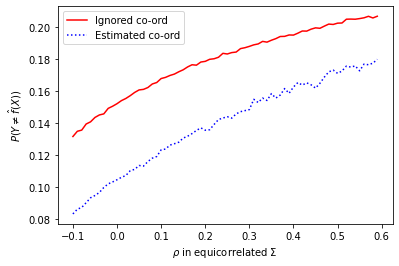

In [8]:
import matplotlib.pyplot as plt
plt.plot(r_vec, errors[:, 0], 'r-', label = 'Ignored co-ord')
plt.plot(r_vec, errors[:, 1], 'b:', label = 'Estimated co-ord')
plt.legend()
plt.xlabel('$\\rho$ in equicorrelated $\\Sigma$')
plt.ylabel('$P(Y\\neq \\hat f(X))$')